## 3. Selection and assessment of existing GSM

### Loading of the model

In [2]:
#KERNEL 3.6!

# First, we can import some functions so we can use the model
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from cameo.strain_design import pathway_prediction

# Second, we can read the GEM and save it as ‘model’
model = read_sbml_model('data/yeastGEM.xml')

# Third, we can show general information about the loaded model
model

Name,M_yeastGEM_v8__46__4__46__2
Memory address,0x07f73082756a0
Number of metabolites,2742
Number of reactions,4058
Number of groups,90
Objective expression,1.0*r_2111 - 1.0*r_2111_reverse_58b69
Compartments,"cell envelope, cytoplasm, extracellular, mitochondrion, nucleus, peroxisome, endoplasmic reticulum, Golgi, lipid particle, vacuole, endoplasmic reticulum membrane, vacuolar membrane, Golgi membrane, mitochondrial membrane"


### Model validation

In [107]:
# NOTE: This field is commented out as it takes ~1 hour to compute every time

#%%time

!memote report snapshot data/yeastGEM.xml --filename yeastGEM.html

============================= test session starts ==============================
platform linux -- Python 3.6.12, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /usr/local/lib/python3.6/dist-packages/memote/suite/tests
collected 146 items / 1 skipped / 145 selected                                 

../../../../usr/local/lib/python3.6/dist-packages/memote/suite/tests/test_annotation.py . [  0%]
..FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF.FFF.FF..FF.F..F.FFFFFFFFFFFFF.         [ 44%]
../../../../usr/local/lib/python3.6/dist-packages/memote/suite/tests/test_basic.py . [ 45%]
.....F........F.F.F.FF                                                   [ 60%]
../../../../usr/local/lib/python3.6/dist-packages/memote/suite/tests/test_biomass.py . [ 60%]
F.....F.F                                                                [ 67%]
../../../../usr/local/lib/python3.6/dist-packages/memote/suite/tests/test_consistency.py F [ 67%]
FFssssssssssssssssFFFFFF.FFF                                             [ 86%]

The file "yeastGEM_prot.html" is the memote analysis. Ramifications of the analysis can be read in the Report document.

### Introduction of heterologous pathway

In this section, the heterologous pathway that makes 7-dehydrocholersterol is added to the GEM

In [2]:
# First reaction

new_reaction1 = Reaction('R07498')  # The first of the three reactions from above

# R07498 uses:
## Zymosterol + NADPH + H+ <=> 5alpha-Cholest-8-en-3beta-ol + NADP+
## We can find these as: (Note: All of these are in the cytoplasm)
### Zymosterol = s_1569[c]
### NADPH      = s_1212[c]
### H+         = s_0794[c]
### 
### 5alpha-Cholest-8-en-3beta-ol = Not yet defined
### NADP+                        = s_1207[c]

# Since 5alpha-Cholest-8-en-3beta-ol does not exist in the model, we will have to define it.
alphaCholest = Metabolite(id='5alpha-Cholest-8-en-3beta-ol_c', name='5alpha-Cholest-8-en-3beta-ol', compartment='c')


# We can now define the reaction stoichiometry
new_reaction1.add_metabolites({
                            model.metabolites.get_by_id("s_1569[c]"): -1,
                            model.metabolites.get_by_id("s_1212[c]"): -1,
                            model.metabolites.get_by_id("s_0794[c]"): -1,
                            alphaCholest: 1, # our newly created metabolites
                            model.metabolites.get_by_id("s_1207[c]"): 1
                             })

model.add_reactions([new_reaction1])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R07498.bounds = -1000, 1000

In [3]:
# Here, we are testing if the intermediate compound can be produced

with model:
    r_5a_exp = model.add_boundary(model.metabolites.get_by_id('5alpha-Cholest-8-en-3beta-ol_c'), type='demand')
    model.objective = r_5a_exp
    sol = model.optimize()
    print(sol.objective_value)

0.04122405543594532


In [4]:
# Second reaction

new_reaction2 = Reaction('R03353')  # The second of the three reactions from above

# R03353 uses:
## Lathosterol <=> 5alpha-Cholest-8-en-3beta-ol
## We can find these as: (Note: All of these are in the cytoplasm)
### 5alpha-Cholest-8-en-3beta-ol = alphaCholest
###
### Lathosterol                  = Not yet defined

# Since Lathosterol does not exist, we will have to define it.
Lathosterol = Metabolite(id='Lathosterol_c', name='Lathosterol', compartment='c')


# We can now define the reaction stoichiometry
new_reaction2.add_metabolites({
                            alphaCholest: -1, # The metabolite from above
                            Lathosterol: 1    # our newly created metabolites
                             })

model.add_reactions([new_reaction2])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R03353.bounds = -1000, 1000

In [5]:
# Here, we are testing if the intermediate compound can be produced

with model:
    r_la_exp = model.add_boundary(model.metabolites.get_by_id('Lathosterol_c'), type='demand')
    model.objective = r_la_exp
    sol = model.optimize()
    print(sol.objective_value)

0.04122405543594526


In [6]:
# Third reaction

new_reaction3 = Reaction('R07215')  # The third of the three reactions from above

## R07215 uses:
## Lathosterol + 2 Ferrocytochromeb5 + Oxygen + 2 H+ <=> 7-Dehydrocholesterol + 2 Ferricytochrome b5 + 2 H2O
## We can find these as: (Note: All of these are in the cytoplasm, except for the cytochromes, which are in the mitochondria)
### Lathosterol          = Lathosterol
### Ferrocytochrome b5   = s_0710[m]
### Oxygen               = s_1275[c]
### H+                   = s_0794[c]
###
### 7-Dehydrocholesterol = Not yet defined
### Ferricytochrome b5   = s_0709[m]
### H2O                  = s_0803[c]



# Since 7-Dehydrocholesterol does not exist, we will have to define it.
Dehydrocholesterol = Metabolite(id='7-Dehydrocholesterol_c', name='7-Dehydrocholesterol', compartment='c')


new_reaction3.add_metabolites({
                            Lathosterol: -1, # The metabolite we created above
                            model.metabolites.get_by_id("s_0710[m]"): -2,
                            model.metabolites.get_by_id("s_1275[c]"): -1,
                            model.metabolites.get_by_id("s_0794[c]"): -2,
                            Dehydrocholesterol: 1, # our newly created metabolites
                            model.metabolites.get_by_id("s_0709[m]"): 2,
                            model.metabolites.get_by_id("s_0803[c]"): 2
                             })

model.add_reactions([new_reaction3])

## Since the reaction can go both ways, we will set the bounds of the reaction to -1000 and 1000
#model.reactions.R07215.bounds = -1000, 1000

In [7]:
r_7DH_export = model.add_boundary(model.metabolites.get_by_id('7-Dehydrocholesterol_c'), type='demand')

with model:
    model.objective = r_7DH_export
    sol = model.optimize()
    print(sol.objective_value)

0.0411734248480485


From this, we can see that we are now able to produce 7-dehydrocholesterol in our cell factory!

The current state of the model is saved as "yeastGEM_het.xml" in the data folder.

In [14]:
write_sbml_model(model, "data/yeastGEM_het.xml")

## 4. Computer-Aided Cell Factory Engineering

### Initial analysis

Now that we have our metablic model with a functional pathway, we can investigate its behavior and experiment with optimization routes.

We will start by loading the updated model, and the we will look at the trade-off with growth.

In [3]:
model = read_sbml_model('data/yeastGEM_het.xml')

In [4]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib

In [5]:
# In this plot, we are looking at the dynamics between the 7-dehydrocholersterol creating reaction (R07215) and the biomass formation reaction (r_2111)
ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)

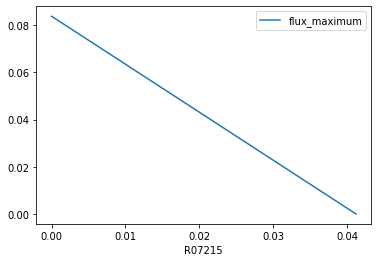

In [6]:
pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
fig = pppp.get_figure()
fig.savefig("figures/initial_ppp")

From this plot, we can see that there is a direct trade-off between production of the target compound and growth.

## In progress stuff
The following sections are not really done yet. Most often it is because the code doesn't work yet.

### Non-automatic optimization

We should probably try to include some of the knockouts and gen upreagulations that we have found in other papers. That could be a very viable strategy.

### Automatic optimization using OptGene

Note: This section of the code is heavily based around the notebook: 09-Predict-gene-knockout-strategies and this notebook: http://cameo.bio/05-predict-gene-knockout-strategies.html

The OptGene algorithm can be used to find genes which can be knocked out or mutated to increase the production of our target compound. The algorithm uses an evolutionary approach, which means that it can take a very long time to run. 
To make the program a tiny bit faster, we can exclude all the essential reactions from the analysis, as they should not be knocked out in any case, as it will cause the growth of the yeast to stop. 

In [8]:
# In this block, we are finding a list of the essential reactions and the non-essential reactions. 
# By looping over all reactions in the model and seeing whether they can grow, we can sort them into the two different lists

#%%time

essential = []
non_essential = []

for reaction in model.reactions:
    with model:
        reaction.knock_out()
        if model.slim_optimize(error_value=0.) == 0.0:
            essential.append(reaction)
        else:
            non_essential.append(reaction)

In [9]:
len(essential)

241

In [10]:
len(non_essential)

3821

In [15]:
# Following this, we can find the genes associated with all of the essential reactions

#%%time
ess = []
for i in range (1,len(essential)):
    for gene in list(essential[i].genes):
        ess.append(gene)

In [16]:
len(ess)

275

In [17]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [18]:
#Lastly, we can run OptGene to find an optimization strategy. 
# Note that the parameters "max_evaluation" and "population_size" are critical for the quality of the output of the analysis, but they also greatly increase the time required to run the code.

optgene = OptGene(model, essential_genes=ess)
result = optgene.run(target=model.reactions.R07215, 
                     biomass=model.reactions.get_by_id("r_2111"),
                     substrate=model.reactions.r_1714,
                     max_evaluations=2000, max_knockouts=5,
                     plot=False)
result

Starting optimization at Sun, 22 Nov 2020 09:33:31


HBox()

Finished after 01:14:30


,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness


Well, this is disappointing. 
The code ran for over an hour, but nothing was found.

In [83]:
#Lastly, we can run OptGene to find an optimization strategy. 
# Note that the parameters "max_evaluation" and "population_size" are critical for the quality of the output of the analysis, but they also greatly increase the time required to run the code.

optgene = OptGene(model, essential_genes=ess)
result = optgene.run(target=model.reactions.R07215, 
                     biomass=model.reactions.get_by_id("r_2111"),
                     substrate=model.reactions.r_1714,
                     max_evaluations=200, population_size=20, max_knockouts=5,
                     plot=True, growth_coupled=False)
result

Starting optimization at Fri, 20 Nov 2020 20:06:00


HBox()

Finished after 00:05:25


,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness


In [ ]:
# The following code should have plotted the results, but for some reason, this error always comes.
# It seems like there is a difference between the environment of the developers and us, as this exact code can run on their end

In [70]:
result.plot()

TypeError: plot() missing 1 required positional argument: 'plotter'

### OptKnock

Similar to OptGene, OptKnock is an algorithm that can produce knock-out strains to increase the target production. 

In [ ]:
from cameo.strain_design.deterministic.linear_programming import OptKnock

In [ ]:
optknock = OptKnock(model, fraction_of_optimum=0.1, exclude_reactions=ess)

In [ ]:
result = optknock.run(max_knockouts=3, target="R07215", biomass="r_2111")

In [ ]:
result

In [ ]:
result.plot(0)

### Phenotypic Phase Plane analysis
A PPP is a great way to learn more about the model and the trade-offs that are going on under the hood.
Unfortuneatly, the plotting error persists and this section needs more work

In [12]:
from cameo import phenotypic_phase_plane

In [13]:
r_7DH_export

Reaction identifier,DM_7-Dehydrocholesterol_c
Name,7-Dehydrocholesterol demand
Memory address,0x02079f3abdc0
Stoichiometry,7-Dehydrocholesterol_c --> 7-Dehydrocholesterol -->
GPR,
Lower bound,0
Upper bound,1000.0


In [21]:
ppp = phenotypic_phase_plane(model,
                             variables=[model.reactions.get_by_id("r_2111")],
                             objective=model.reactions.get_by_id("R07215"))

ppp.plot()

TypeError: plot() missing 1 required positional argument: 'plotter'

### FSEOF analysis
We should be able to use FSEOF for something, but, as of writing, I am not sure how to actually use the information here.

In [15]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [16]:
fseof = FSEOF(model)

In [17]:
fseof.run(target=model.reactions.R07215)

,1,2,3,4,5,6,7,8,9,10
r_0020,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0039,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0040,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0045,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
r_0058,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
...,...,...,...,...,...,...,...,...,...,...
r_4262,0.085993,0.085154,0.075808,0.066462,0.057116,0.047770,0.038424,0.029078,0.019732,0.010386
r_4460,-0.292889,-0.334250,-0.375589,-0.416928,-0.458267,-0.499607,-0.540946,-0.582285,-0.623624,-0.664963
R07498,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056
R03353,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056


### More PPP
Here, a PPP analysis was conducted usin slightly different code, but the same plotting error persists

In [18]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA

In [19]:
production = phenotypic_phase_plane(model,
                                             variables=[model.reactions.get_by_id("r_2111")],
                                             objective=model.metabolites.get_by_id("7-Dehydrocholesterol_c"))
production.plot(height=400)

TypeError: plot() missing 1 required positional argument: 'plotter'

### Visualization with escher
Apparently, escher also has a yeast model that we can look at.
This section tries to visualize the changes in the model to see where the reaction fluxes go, but as can be seen, no real information has been extracted yet. 

In [86]:
import escher
from IPython.display import IFrame

In [87]:
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [88]:
escher.Builder('iMM904.Central carbon metabolism').display_in_notebook()

/usr/local/lib/python3.6/dist-packages/escher/plots.py:155 UserWarning: Map not in cache. Attempting download from https://escher.github.io/1-0-0/5/maps/Saccharomyces%20cerevisiae/iMM904.Central%20carbon%20metabolism.json


In [89]:
sol

,fluxes,reduced_costs
r_0001,0.000000,0.000000e+00
r_0002,0.000000,0.000000e+00
r_0003,0.000000,0.000000e+00
r_0004,0.000000,-1.912628e-03
r_0005,0.000000,0.000000e+00
...,...,...
r_4699,0.000000,-7.810901e-02
R07498,0.041173,-2.775558e-17
R03353,0.041173,0.000000e+00
R07215,0.041173,4.640385e-17


In [90]:
escher.Builder('iMM904.Central carbon metabolism', reaction_data=sol.fluxes.to_dict()).display_in_notebook()